In [1]:
# Importing necessary libraries for image processing, neural networks, and handling images
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
import warnings
import numpy as np
import cv2
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Initialize background and set parameters for ROI (Region of Interest)
background = None
accumulated_weight = 0.5

# Defining the Region of Interest dimensions
ROI_top = 10
ROI_bottom = 550
ROI_right = 10
ROI_left = 800

# Function to calculate accumulated average for background subtraction
def cal_accum_avg(frame, accumulated_weight):

    global background
    
    if background is None:
        background = frame.copy().astype("float")
        return None

    cv2.accumulateWeighted(frame, background, accumulated_weight)

In [2]:
# Function to segment the hand region from the background
def segment_hand(frame, threshold=25):
    
    global background
    
    # Calculate the absolute difference between the background and the current frame
    diff = cv2.absdiff(background.astype("uint8"), frame)

    # Apply threshold to get a binary image
    _ , thresholded = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)

    # Find contours in the thresholded image
    contours, hierarchy = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return None
    else:
        
        hand_segment_max_cont = max(contours, key=cv2.contourArea)
        
        return (thresholded, hand_segment_max_cont)

In [40]:
# Start capturing video from the webcam
cam = cv2.VideoCapture(0)
cam.set(3,900)
cam.set(4,1200)
num_frames = 0
element = 5
num_imgs_taken = 0

# Start an infinite loop to process each frame
while True:
    ret, frame = cam.read()

    # Flip the frame horizontally
    frame = cv2.flip(frame, 1)

    frame_copy = frame.copy()

    roi = frame[ROI_top:ROI_bottom, ROI_right:ROI_left]

    # Convert the ROI to grayscale and blur it
    gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)

    # Calculate the accumulated average for background subtraction after 60 frames
    if num_frames < 60:
        cal_accum_avg(gray_frame, accumulated_weight)
        if num_frames <= 59:
            
            cv2.putText(frame_copy, "FETCHING BACKGROUND...PLEASE WAIT", (80, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
            #cv2.imshow("Sign Detection",frame_copy)
         
    #Time to configure the hand specifically into the ROI
    elif num_frames <= 300: 

        hand = segment_hand(gray_frame)
        
        cv2.putText(frame_copy, "Adjust hand...Gesture for" + str(element), (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
        
        # Checking if hand is actually detected by counting number of contours detected
        if hand is not None:
            
            thresholded, hand_segment = hand

            # Draw contours around hand segment
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right, ROI_top)], -1, (255, 0, 0),1)
            
            cv2.putText(frame_copy, str(num_frames)+"For" + str(element), (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

            # Also display the thresholded image
            cv2.imshow("Thresholded Hand Image", thresholded)
    
    else: 
        
        # Segmenting the hand region...
        hand = segment_hand(gray_frame)
        
        # Checking if we are able to detect the hand...
        if hand is not None:
            
            # unpack the thresholded img and the max_contour...
            thresholded, hand_segment = hand

            # Drawing contours around hand segment
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right, ROI_top)], -1, (255, 0, 0),1)
            
            cv2.putText(frame_copy, str(num_frames), (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            #cv2.putText(frame_copy, str(num_frames)+"For" + str(element), (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            cv2.putText(frame_copy, str(num_imgs_taken) + 'images' +"For" + str(element), (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            
            # Displaying the thresholded image
            cv2.imshow("Thresholded Hand Image", thresholded)
            if num_imgs_taken <= 300:
                cv2.imwrite(r"C:\\Users\\91773\\Mini Project\\train\\"+str(element)+"\\" + str(num_imgs_taken+300) + '.jpg', thresholded)
                #cv2.imwrite(r"D:\\gesture\\x"+"\\" + str(num_imgs_taken) + '.jpg', thresholded)
            else:
                break
            num_imgs_taken +=1
        else:
            cv2.putText(frame_copy, 'No hand detected...', (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

    # Drawing ROI on frame copy
    cv2.rectangle(frame_copy, (ROI_left, ROI_top), (ROI_right, ROI_bottom), (255,128,0), 3)
    
    cv2.putText(frame_copy, "DataFlair hand sign recognition_ _ _", (10, 20), cv2.FONT_ITALIC, 0.5, (51,255,51), 1)
    
    # increment the number of frames for tracking
    num_frames += 1

    # Display the frame with segmented hand
    cv2.imshow("Sign Detection", frame_copy)

    # Break the loop when the ESC key is pressed 
    k = cv2.waitKey(1) & 0xFF

    if k == 27:
        break

# Release the camera & close all windows
cv2.destroyAllWindows()
cam.release()

In [41]:
train_path = r'C:\Users\91773\Mini Project\train'
test_path = r'C:\Users\91773\Mini Project\test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(64,64), class_mode='categorical', batch_size=10,shuffle=True)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(64,64), class_mode='categorical', batch_size=10, shuffle=True)

Found 1200 images belonging to 5 classes.
Found 305 images belonging to 5 classes.


In [42]:
from matplotlib import pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

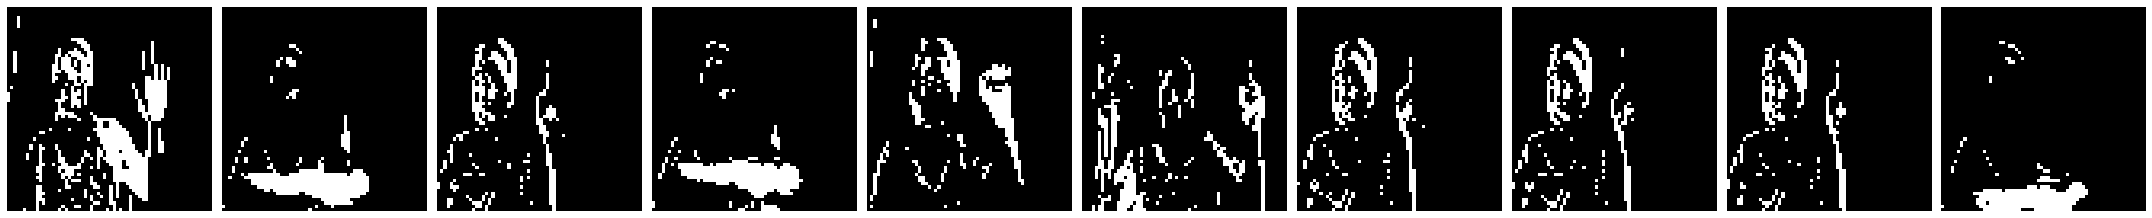

(10, 64, 64, 3)
[[0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [43]:
imgs, labels = next(train_batches)


#Plotting the images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(30,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


plotImages(imgs)
print(imgs.shape)
print(labels)

In [1]:
!pip install scipy

  Using cached scipy-1.8.0-cp310-cp310-win_amd64.whl (37.0 MB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
object-detection 0.1 requires apache-beam, which is not installed.
object-detection 0.1 requires avro-python3, which is not installed.
object-detection 0.1 requires contextlib2, which is not installed.
object-detection 0.1 requires Cython, which is not installed.
object-detection 0.1 requires lvis, which is not installed.
object-detection 0.1 requires pycocotools, which is not installed.
object-detection 0.1 requires tensorflow_io, which is not installed.
object-detection 0.1 requires tf-models-official>=2.5.1, which is not installed.


In [44]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64,64,3)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Flatten())

model.add(Dense(64,activation ="relu"))
model.add(Dense(128,activation ="relu"))
#model.add(Dropout(0.2))
model.add(Dense(128,activation ="relu"))
#model.add(Dropout(0.3))
model.add(Dense(5,activation ="softmax"))

In [45]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0005)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

In [46]:
history2 = model.fit(train_batches, epochs=10, callbacks=[reduce_lr, early_stop],  validation_data = test_batches)

Epoch 1/10
120/120 [==============================] - 69s 388ms/step - loss: 1.8263 - accuracy: 0.9492 - val_loss: 0.5239 - val_accuracy: 0.8098 - lr: 0.0010
Epoch 2/10
120/120 [==============================] - 8s 63ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.5002 - val_accuracy: 0.8197 - lr: 0.0010
Epoch 3/10
120/120 [==============================] - 7s 59ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.4788 - val_accuracy: 0.8295 - lr: 0.0010
Epoch 4/10
120/120 [==============================] - 8s 64ms/step - loss: 7.8010e-04 - accuracy: 1.0000 - val_loss: 0.4712 - val_accuracy: 0.8295 - lr: 0.0010
Epoch 5/10
120/120 [==============================] - 8s 69ms/step - loss: 5.8311e-04 - accuracy: 1.0000 - val_loss: 0.4624 - val_accuracy: 0.8393 - lr: 0.0010
Epoch 6/10
120/120 [==============================] - 9s 76ms/step - loss: 4.6368e-04 - accuracy: 1.0000 - val_loss: 0.4537 - val_accuracy: 0.8393 - lr: 0.0010
Epoch 7/10
120/120 [==============================

In [47]:
imgs, labels = next(train_batches) 

imgs, labels = next(test_batches)
scores = model.evaluate(imgs, labels, verbose=0)
print(f'{model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')


#model.save('best_model_dataflair.h5')
model.save('best_model_dataflair3.h5')


loss of 0.0014339596964418888; accuracy of 100.0%


In [48]:
print(history2.history)

{'loss': [1.8263061046600342, 0.0022573661990463734, 0.0011674984125420451, 0.0007800954044796526, 0.0005831113667227328, 0.0004636790254153311, 0.00038326214416883886, 0.0003260004159528762, 0.00028320233104750514, 0.0002499150577932596], 'accuracy': [0.9491666555404663, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'val_loss': [0.523883581161499, 0.5002407431602478, 0.47880828380584717, 0.47119367122650146, 0.4623553156852722, 0.4536508023738861, 0.4472721219062805, 0.44385355710983276, 0.4392538070678711, 0.4368702471256256], 'val_accuracy': [0.8098360896110535, 0.8196721076965332, 0.8295081853866577, 0.8295081853866577, 0.8393442630767822, 0.8393442630767822, 0.8393442630767822, 0.8393442630767822, 0.8393442630767822, 0.8393442630767822], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]}


In [49]:
imgs, labels = next(test_batches)

model = keras.models.load_model(r"best_model_dataflair3.h5")

scores = model.evaluate(imgs, labels, verbose=0)
print(f'{model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

model.summary()

scores #[loss, accuracy] on test data.
model.metrics_names


loss of 0.5267590284347534; accuracy of 69.9999988079071%
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                

['loss', 'accuracy']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

predictions on a small set of test data--

wide   noball   wide   out   out   wide   wide   four   wide   wide   

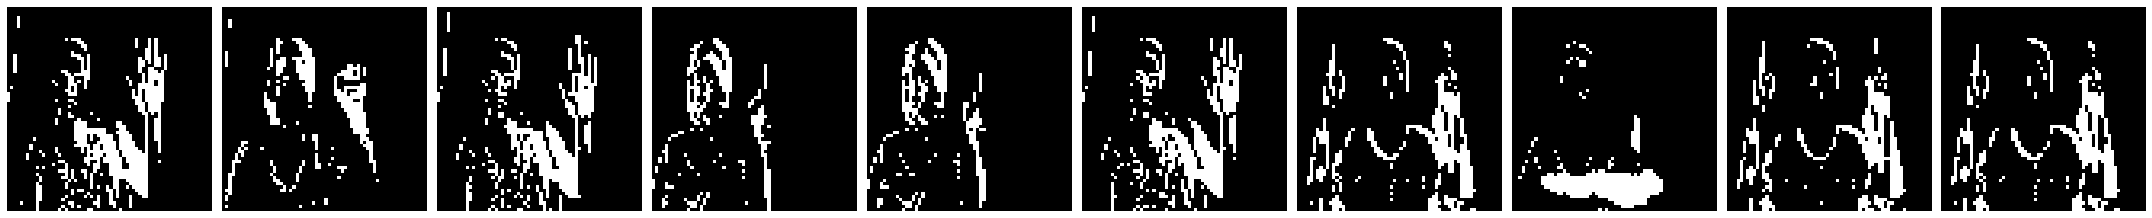

Actual labels
wide   noball   wide   out   out   wide   six   four   six   six   

In [50]:
word_dict = {0:'four',1:'noball',2:'out',3:'six',4:'wide'}

predictions = model.predict(imgs, verbose=0)
print("predictions on a small set of test data--")
print("")
for ind, i in enumerate(predictions):
    print(word_dict[np.argmax(i)], end='   ')

plotImages(imgs)
print('Actual labels')
for i in labels:
    print(word_dict[np.argmax(i)], end='   ')